# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
#!pip install --upgrade pandas

## 1. Import Libraries and Read in the Data

In [2]:
# import the necessary libraries
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

**portfolio metadata:**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [4]:
# View the offer portfolio data
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [5]:
# View how many offers are in the offer data
portfolio.shape

(10, 6)

> **There are 10 different offers in the portfolio data**

**profile metadata:**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [6]:
# View the customer profile data
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
# View how many customers are in the profile data
profile.shape

(17000, 5)

In [8]:
# Determine if there are any duplicates
profile.duplicated(subset=['id']).sum()

0

> **There are 17,000 customers in the profile data**

**transcript metadata:**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [9]:
# View the transaction data
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [10]:
# View how many transations are in the transcript data
transcript.shape

(306534, 4)

> **There are 306,534 transactions (events) in the transcript file**

## 2. Explore and clean the data files
### Portfolio (offer) data:

In [11]:
# Create function to clean the portfolio data

def clean_portfolio(portfolio):
    '''
    This function cleans the portfolio data for analysis:
        creates dummy variables for the different channels
        renames the id column
        converts duration to hours
    
    INPUT:
    portfolio - dataframe containing offer ids and meta data about each offer (duration, type, etc.)
    
    OUTPUT:
    portfolio_clean - portfolio dataframe with cleaning process applied
    '''
        
    # Rename the id column to offer_id
    portfolio.rename(columns={'id':'offer_id'}, inplace=True)
    
    # Create dummy variables for the different channels
    channels = pd.get_dummies(portfolio.channels.apply(pd.Series).stack(), prefix="ch_").sum(level=0)
    
    # Merge the new dummy variables into the original dataframe
    portfolio_clean = pd.concat([portfolio, channels], axis =1, sort = False)
    
    #Update the time value to be hours to coincide with the transaction data
    portfolio_clean['duration'] = portfolio_clean['duration']*24
    
    # Drop the original channels column
    portfolio_clean.drop('channels', axis = 1, inplace = True)

    return portfolio_clean

In [12]:
# Apply the cleaning function and view the data
portfolio_clean = clean_portfolio(portfolio)
portfolio_clean.head(10)

,difficulty,duration,offer_id,offer_type,reward,ch__email,ch__mobile,ch__social,ch__web
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,72,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


### Profile (customer) data:

In [13]:
# View the distribution of age and income
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [14]:
#View the distribtion of the highest ages
profile.age.value_counts().sort_index(ascending=False).head()

118    2175
101       5
100      12
99        5
98        5
Name: age, dtype: int64

> **It seems that the customers have been assigned the value 118 for age if there age was missing**

In [15]:
#Check for missing values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

> **It appears that 2175 individuals did not complete the demographics on their profile. I will be removing these individuals from my analysis**

In [16]:
# Create function to clean the profile data

def clean_profile(profile):
    '''
    This function cleans the profile data for analysis:
        rename columns
        rename the values of gender
        create new columns for upcoming analysis
        remove individuals with missing demographic data
    
    INPUT:
    profile - dataframe containing demographic data for each customer
    
    OUTPUT:
    profile_clean - profile dataframe with cleaning process applied
    '''
        
    # Rename the id column to customer_id
    profile.rename(columns={'id':'customer_id'}, inplace=True)
    
    # Create dummy variables for the different genders
    genders = pd.get_dummies(profile.gender, prefix="gender")
    # Rename the gender columns
    genders.rename(columns={'gender_F':'female', 'gender_M':'male', 'gender_O':'other_gender'}, inplace=True)
    
    # Merge the new dummy variables into the original dataframe
    profile_clean = pd.concat([profile, genders], axis =1, sort = False)
    
    # Convert the became_member_on column from an integer to a date field
    profile_clean['became_member_on'] = pd.to_datetime(profile_clean['became_member_on'], format='%Y%m%d')
    
    # Convert the age values of 118 to missing values
    profile_clean['age'] = profile_clean['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # Create a column for the length of time a customer has been a Starbucks member
    #profile['days_member'] = datetime.datetime.today().date() - profile_clean['became_member_on'].dt.date
    profile_clean['days_member'] = (date.today() - profile_clean['became_member_on'].dt.date).dt.days
    
    #Create categorical column for age
    profile_clean['age_cat'] = pd.cut(profile_clean.age, bins=[0,30,40,50,60,70,80,101], 
                                      labels=['0-30','31-40','41-50','51-60','61-70','71-80','81+'])
    
    #Create categorical column for income
    profile_clean['income_cat'] = pd.cut(profile_clean.income, bins=[0,45000,60000,75000,90000,120000], 
                                      labels=['0-45k','46-60k','61-75k','76k-90k','91-120k'])
    
    #Create categorical column for days as a member
    profile_clean['member_cat'] = pd.cut(profile_clean.days_member, bins=[0,1500,2000,2500,3000], 
                                      labels=['0-1500','1501-2000','2001-2500','2501-3000'])    
    
    #Drop the customers with missing demographic information
    profile_clean = profile_clean.dropna(subset=['income'], axis = 0)
    
    # Drop the original gender column
    #profile_clean.drop('gender', axis = 1, inplace = True)
    
    return profile_clean

In [17]:
# Apply the cleaning function and view the data
profile_clean = clean_profile(profile)
profile_clean.head()

,age,became_member_on,gender,customer_id,income,female,male,other_gender,days_member,age_cat,income_cat,member_cat
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,1510,51-60,91-120k,1501-2000
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,1577,71-80,91-120k,1501-2000
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,1225,61-70,61-75k,0-1500
8,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,1301,61-70,46-60k,0-1500
12,58.0,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,1391,51-60,46-60k,0-1500


In [18]:
# View how many customers are in the cleaned profile data
profile_clean.shape

(14825, 12)

> **There are 14,825 customers in our cleaned profile data**

In [19]:
#Recheck for missing values
profile_clean.isnull().sum()

age                 0
became_member_on    0
gender              0
customer_id         0
income              0
female              0
male                0
other_gender        0
days_member         0
age_cat             0
income_cat          0
member_cat          0
dtype: int64

### Transcript (transaction) data:

In [20]:
# View the data in a sorted order to see the pattern for one person
transcript.sort_values(by=['person', 'time']).head(10)

,event,person,time,value
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16}
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
168412,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57}
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
204340,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


In [21]:
# View all the values for the event column
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [22]:
# Create function to clean the transaction data

def clean_transcript(transcript, profile_clean):
    '''
    This function cleans the transcript data for analysis:
        rename some columns
        rename the values of some columns
        create new columns for upcoming analysis
        remove customers with missing demographic data
    
    INPUT:
    transcript - dataframe containing records for transactions, offers received, offers viewed, and offers completed
    
    OUTPUT:
    transcript_clean - transcript dataframe with cleaning process applied
    '''
        
    # Rename the person column to customer_id
    transcript.rename(columns={'person':'customer_id'}, inplace=True)
    
    # Create dummy variables for the different events (first replace the blanks with an underscore)
    transcript.event = transcript.event.str.replace(' ','_')
    events = pd.get_dummies(transcript.event, prefix="event")
    
    # Merge the new dummy variables into the original dataframe
    transcript_clean = pd.concat([transcript, events], axis =1, sort = False)
    
    # Create the offer id column from the value column
    transcript_clean['offer_id'] = transcript_clean['value'].apply(lambda x: x['offer id'] if ('offer id' in x) 
                                                                   else (x['offer_id'] if ('offer_id' in x) else np.nan))
    # Create the amount column from the value column
    transcript_clean['amount'] = transcript_clean['value'].apply(lambda x: x['amount'] if ('amount' in x) else np.nan)

    # Create the time to complete offer column from the time column
    transcript_clean['time_completed'] = np.where(transcript_clean['event_offer_completed'] == 1, transcript_clean['time'], 
                                                  np.nan)

    # Create the time to view offer column from the time column
    transcript_clean['time_viewed'] = np.where(transcript_clean['event_offer_viewed'] == 1, transcript_clean['time'],np.nan)

    # Create the time to receive offer column from the time column
    transcript_clean['time_received'] = np.where(transcript_clean['event_offer_received'] == 1, transcript_clean['time'], np.nan)

    # Create the time to transaction column from the time column
    transcript_clean['time_trxn'] = np.where(transcript_clean['event_transaction'] == 1, transcript_clean['time'], np.nan)  
    
    # Sort the records by customer and time
    transcript_clean = transcript_clean.sort_values(by=['customer_id', 'time'])
    
    # Carry down the time_recieved value until the next offer is recieved
    #transcript_clean['time_received2'] = transcript_clean['time_received']
    #transcript_clean['time_received2'].fillna(method='ffill', inplace=True)
    
    # Filter out the customers with missing demographic information
    transcript_clean = transcript_clean[transcript_clean.customer_id.isin(profile_clean.customer_id)]
    
    # Drop the original value colums
    transcript_clean.drop(columns =['value'], inplace = True)

    return transcript_clean

In [23]:
#Apply the function above to clean the transcript data
transcript_clean = clean_transcript(transcript, profile_clean)
transcript_clean.head(10)

,event,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,time_completed,time_viewed,time_received,time_trxn
55972,offer_received,0009655768c64bdeb2e877511632db8f,168,0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,168.0,NaN
77705,offer_viewed,0009655768c64bdeb2e877511632db8f,192,0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,192.0,NaN,NaN
89291,transaction,0009655768c64bdeb2e877511632db8f,228,0,0,0,1,NaN,22.16,NaN,NaN,NaN,228.0
113605,offer_received,0009655768c64bdeb2e877511632db8f,336,0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,336.0,NaN
139992,offer_viewed,0009655768c64bdeb2e877511632db8f,372,0,0,1,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,372.0,NaN,NaN
153401,offer_received,0009655768c64bdeb2e877511632db8f,408,0,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN,408.0,NaN
168412,transaction,0009655768c64bdeb2e877511632db8f,414,0,0,0,1,NaN,8.57,NaN,NaN,NaN,414.0
168413,offer_completed,0009655768c64bdeb2e877511632db8f,414,1,0,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,414.0,NaN,NaN,NaN
187554,offer_viewed,0009655768c64bdeb2e877511632db8f,456,0,0,1,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,456.0,NaN,NaN
204340,offer_received,0009655768c64bdeb2e877511632db8f,504,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,504.0,NaN


In [24]:
transcript_clean.shape

(272762, 13)

> **There are 272,762 transactions (events) in the cleaned transcript file**

In [25]:
transcript_clean.describe()

,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,amount,time_completed,time_viewed,time_received,time_trxn
count,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,123957.000000,32444.000000,49860.000000,66501.000000,123957.000000
mean,366.707694,0.118946,0.243806,0.182797,0.454451,13.996325,399.615645,354.547533,332.610818,381.278201
std,200.359087,0.323726,0.429378,0.386500,0.497922,31.749420,192.577529,199.405552,196.528671,201.829085
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000
25%,186.000000,0.000000,0.000000,0.000000,0.000000,3.660000,234.000000,180.000000,168.000000,210.000000
50%,408.000000,0.000000,0.000000,0.000000,0.000000,10.800000,432.000000,408.000000,408.000000,402.000000
75%,528.000000,0.000000,0.000000,0.000000,1.000000,19.130000,558.000000,516.000000,504.000000,552.000000
max,714.000000,1.000000,1.000000,1.000000,1.000000,1062.280000,714.000000,714.000000,576.000000,714.000000


In [26]:
#transcript_clean['event_offer_received'].sum()

### Merge the three datasets together to create new dataframe

In [27]:
#Merge the transcript and portfolio data together
transcript2 = pd.merge(transcript_clean, portfolio_clean, on = 'offer_id', how = 'left')
transcript2.head(10)

,event,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,time_completed,time_viewed,time_received,time_trxn,difficulty,duration,offer_type,reward,ch__email,ch__mobile,ch__social,ch__web
0,offer_received,0009655768c64bdeb2e877511632db8f,168,0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,168.0,NaN,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0
1,offer_viewed,0009655768c64bdeb2e877511632db8f,192,0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,192.0,NaN,NaN,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,0,0,0,1,NaN,22.16,NaN,NaN,NaN,228.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer_received,0009655768c64bdeb2e877511632db8f,336,0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,336.0,NaN,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0
4,offer_viewed,0009655768c64bdeb2e877511632db8f,372,0,0,1,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,372.0,NaN,NaN,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0
5,offer_received,0009655768c64bdeb2e877511632db8f,408,0,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN,408.0,NaN,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0
6,transaction,0009655768c64bdeb2e877511632db8f,414,0,0,0,1,NaN,8.57,NaN,NaN,NaN,414.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,offer_completed,0009655768c64bdeb2e877511632db8f,414,1,0,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,414.0,NaN,NaN,NaN,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0
8,offer_viewed,0009655768c64bdeb2e877511632db8f,456,0,0,1,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,456.0,NaN,NaN,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0
9,offer_received,0009655768c64bdeb2e877511632db8f,504,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,504.0,NaN,10.0,240.0,discount,2.0,1.0,1.0,1.0,1.0


In [28]:
# View the number of different offers and the corresponding offer types
pd.crosstab(transcript2.offer_id,transcript2.offer_type)

offer_type,bogo,discount,informational
offer_id,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,0,12327,0
2298d6c36e964ae4a3e7e9706d1fb8c2,0,17920,0
2906b810c7d4411798c6938adc9daaa5,0,14002,0
3f207df678b143eea3cee63160fa8bed,0,0,10144
4d5c57ea9a6940dd891ad53e9dbe8da0,16232,0,0
5a8bc65990b245e5a138643cd4eb9837,0,0,12516
9b98b8c7a33c4b65b9aebfe6a799e6d9,14372,0,0
ae264e3637204a6fb9bb56bc8210ddfd,16241,0,0
f19421c1d4aa40978ebb69ca19b0e20d,16989,0,0


In [29]:
# Rename the offer_ids into something more understandable
transcript2['offer_id'] = transcript2['offer_id'].replace({'4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo1',
                                                           '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo2',
                                                           'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo3', 
                                                           'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo4',
                                                           '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount1',
                                                           '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discount2',
                                                           '2906b810c7d4411798c6938adc9daaa5': 'discount3',
                                                           'fafdcd668e3743c1bb461111dcafc2a4': 'discount4',
                                                           '3f207df678b143eea3cee63160fa8bed': 'info1',
                                                           '5a8bc65990b245e5a138643cd4eb9837': 'info2'})

In [30]:
# Check transcript2 file
#transcript2.head(10)

In [31]:
#Merge the above file with the profile data
starbucks_data = pd.merge(transcript2, profile_clean, on = 'customer_id', how = 'left')
starbucks_data.sort_values(by=['customer_id', 'time']).head()

,event,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,time_completed,time_viewed,time_received,time_trxn,difficulty,duration,offer_type,reward,ch__email,ch__mobile,ch__social,ch__web,age,became_member_on,gender,income,female,male,other_gender,days_member,age_cat,income_cat,member_cat
0,offer_received,0009655768c64bdeb2e877511632db8f,168,0,1,0,0,info2,NaN,NaN,NaN,168.0,NaN,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0,33.0,2017-04-21,M,72000.0,0,1,0,1595,31-40,61-75k,1501-2000
1,offer_viewed,0009655768c64bdeb2e877511632db8f,192,0,0,1,0,info2,NaN,NaN,192.0,NaN,NaN,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0,33.0,2017-04-21,M,72000.0,0,1,0,1595,31-40,61-75k,1501-2000
2,transaction,0009655768c64bdeb2e877511632db8f,228,0,0,0,1,NaN,22.16,NaN,NaN,NaN,228.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,2017-04-21,M,72000.0,0,1,0,1595,31-40,61-75k,1501-2000
3,offer_received,0009655768c64bdeb2e877511632db8f,336,0,1,0,0,info1,NaN,NaN,NaN,336.0,NaN,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0,33.0,2017-04-21,M,72000.0,0,1,0,1595,31-40,61-75k,1501-2000
4,offer_viewed,0009655768c64bdeb2e877511632db8f,372,0,0,1,0,info1,NaN,NaN,372.0,NaN,NaN,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0,33.0,2017-04-21,M,72000.0,0,1,0,1595,31-40,61-75k,1501-2000


In [32]:
starbucks_data.shape

(272762, 32)

> **There are 272,762 transactions in our merged dataframe**

#### Create a dataframe with one line per Customer/Offer & Purchases

In [33]:
# Create function to create one line per customer/offer

def cust_offer(transcript_clean, profile_clean, portfolio_clean):
    '''
    This function merges the three cleaned dfs and creates a new dataframe with one line per customer/offer/transaction
    for analysis    
    
    INPUT:
    transcript_clean - cleaned transcript dataframe
    profile_clean - cleaned profile dataframe
    portfolio_clean - cleaned portfolio dataframe
    
    OUTPUT:
    transcript_clean - transcript dataframe with cleaning process applied
    '''
    
    # Create new time completed column getting the max value for each customer/time combination
    trans_temp = transcript_clean.groupby(['customer_id', 'time'])['time_completed'].max().reset_index()
    trans_temp.rename(columns={'time_completed':'time_completed_max'}, inplace=True)
    
    # Merge new time_completed column back into the dataframe
    trans_temp2 = pd.merge(transcript_clean, trans_temp, on = ['customer_id', 'time'], how = 'left')
    
    # Create new offer id column getting the first value for each customer/time combination
    # First sort the data to get the correct 'first' value in the sort
    transcript_clean2 = transcript_clean.sort_values(by=['customer_id', 'time', 'event'])
    # Create the new column
    trans_temp3 = transcript_clean2.groupby(['customer_id', 'time'])['offer_id'].first().reset_index()
    trans_temp3.rename(columns={'offer_id':'offer_id_tmp'}, inplace=True)
    
    # Merge new offer_id column back into the dataframe
    trans_temp4 = pd.merge(trans_temp2, trans_temp3, on = ['customer_id', 'time'], how = 'left')
    # Correct the offer id for cases where one offer was overlapped with another
    trans_temp4['offer_id_new'] = np.where(trans_temp4['offer_id'].isna(), trans_temp4['offer_id_tmp'], trans_temp4['offer_id'])
    
    # Drop the original columns being replaced
    trans_temp4.drop(['event', 'time', 'offer_id', 'time_completed', 'offer_id_tmp'], axis = 1, inplace = True)
       
    # Create a dataframe of the purchases not associated with an offer
    no_offer = trans_temp4[trans_temp4.offer_id_new.isnull()]
    
    # Get one row of data per customer/offer id
    offer = trans_temp4[trans_temp4.offer_id_new.notnull()]
    offer2 = offer.groupby(['customer_id', 'offer_id_new'], as_index=False).max()
    
    # Combine the no offers and offers together
    cust_offer = pd.concat([offer2, no_offer], sort = True)
    cust_offer = cust_offer.sort_values(by=['customer_id'])
   
    # Drop time_completed column from transcript_clean df
    cust_offer.rename(columns={'offer_id_new':'offer_id', 'time_completed_max':'time_completed'}, inplace=True)
    
    # Add in offer details
    cust_offer2 = pd.merge(cust_offer, portfolio_clean, on = 'offer_id', how = 'left')

    # Rename the offer_ids into something more understandable
    cust_offer2['offer_id'] = cust_offer2['offer_id'].replace({'4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo1',
                                                               '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo2',
                                                               'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo3', 
                                                               'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo4',
                                                               '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount1',
                                                               '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discount2',
                                                               '2906b810c7d4411798c6938adc9daaa5': 'discount3',
                                                               'fafdcd668e3743c1bb461111dcafc2a4': 'discount4',
                                                               '3f207df678b143eea3cee63160fa8bed': 'info1',
                                                               '5a8bc65990b245e5a138643cd4eb9837': 'info2',
                                                               None: 'No offer'})
    
    # Rename the missing offer type to No offer 
    cust_offer2['offer_type'] = cust_offer2['offer_type'].replace({None: 'No offer'})
    
    #Create a new column called event_offer_viewed_new to code those who viewed the offer after their purchase as 'not 'viewed'
    cust_offer2['event_offer_viewed2'] = np.where(cust_offer2['time_viewed'] > cust_offer2['time_completed'],
                                                  0, cust_offer2['event_offer_viewed'])
    
    # Create a new column called offer_id2 where those who have not viewed the offer or viewed the offer after their purchase
    # are considered to have been given no offer
    cust_offer2['offer_id2'] = np.where(cust_offer2['event_offer_viewed2'] == 1, cust_offer2['offer_id'], 'No offer')

    # Create a new column called offer_type2 where those who have not viewed the offer or viewed the offer after their 
    # purchase are considered to have been given no offer
    cust_offer2['offer_type2'] = np.where(cust_offer2['event_offer_viewed2'] == 1, cust_offer2['offer_type'], 'No offer')
    
    # Create a new column called responded_to_offer for those who viewed (prior to purchase) and completed the offer 
    cust_offer2['responded_to_offer'] = np.where((cust_offer2['event_offer_viewed2'] == 1) & 
                                                 (cust_offer2['event_offer_completed'] == 1), 1, 0)
    
    #Create a new column called offer_responded_to to categorize the offer types customers responded to
    cust_offer2['offer_responded_to'] = np.select([(cust_offer2['offer_type'] == 'bogo') & (cust_offer2['responded_to_offer'] == 1),
                                                   (cust_offer2['offer_type'] == 'discount') & (cust_offer2['responded_to_offer'] == 1)],
                                                   ['bogo', 'discount'], 'no offer response')
     
    #Create a new column called offer_id_responded_to to categorize the offer id customers responded to
    cust_offer2['offer_id_responded_to'] = np.where((cust_offer2['offer_responded_to'] == 'no offer response'), 'no offer response', 
                                                   cust_offer2['offer_id2'])
    
    #Create a new column called offer_response to categorize whether a customer responded to an offer
    cust_offer2['offer_response'] = np.where((cust_offer2['offer_responded_to'] == 'bogo') | 
                                             (cust_offer2['offer_responded_to'] == 'discount'), 'offer', 'no offer')    
                                                   
    # Add in customer demographics
    cust_offer_details = pd.merge(cust_offer2, profile_clean, on = 'customer_id', how = 'left')
    cust_offer_details.sort_values(by=['customer_id']).head()
      
    return cust_offer_details

In [34]:
# Apply the function to create a dataframe for each customer/offer/transacction combination
cust_offer_details = cust_offer(transcript_clean, profile_clean, portfolio_clean)
cust_offer_details.head(15)

,amount,customer_id,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,time_completed,time_received,time_trxn,time_viewed,difficulty,duration,offer_type,reward,ch__email,ch__mobile,ch__social,ch__web,event_offer_viewed2,offer_id2,offer_type2,responded_to_offer,offer_responded_to,offer_id_responded_to,offer_response,age,became_member_on,gender,income,female,male,other_gender,days_member,age_cat,income_cat,member_cat
0,10.27,0009655768c64bdeb2e877511632db8f,1,1,0,1,discount3,576.0,576.0,576.0,NaN,10.0,168.0,discount,2.0,1.0,1.0,0.0,1.0,0,No offer,No offer,0,no offer response,no offer response,no offer,33.0,2017-04-21,M,72000.0,0,1,0,1595,31-40,61-75k,1501-2000
1,12.36,0009655768c64bdeb2e877511632db8f,0,0,0,1,No offer,NaN,NaN,660.0,NaN,NaN,NaN,No offer,NaN,NaN,NaN,NaN,NaN,0,No offer,No offer,0,no offer response,no offer response,no offer,33.0,2017-04-21,M,72000.0,0,1,0,1595,31-40,61-75k,1501-2000
2,28.16,0009655768c64bdeb2e877511632db8f,0,0,0,1,No offer,NaN,NaN,690.0,NaN,NaN,NaN,No offer,NaN,NaN,NaN,NaN,NaN,0,No offer,No offer,0,no offer response,no offer response,no offer,33.0,2017-04-21,M,72000.0,0,1,0,1595,31-40,61-75k,1501-2000
3,18.41,0009655768c64bdeb2e877511632db8f,0,0,0,1,No offer,NaN,NaN,696.0,NaN,NaN,NaN,No offer,NaN,NaN,NaN,NaN,NaN,0,No offer,No offer,0,no offer response,no offer response,no offer,33.0,2017-04-21,M,72000.0,0,1,0,1595,31-40,61-75k,1501-2000
4,13.56,0009655768c64bdeb2e877511632db8f,0,0,0,1,No offer,NaN,NaN,552.0,NaN,NaN,NaN,No offer,NaN,NaN,NaN,NaN,NaN,0,No offer,No offer,0,no offer response,no offer response,no offer,33.0,2017-04-21,M,72000.0,0,1,0,1595,31-40,61-75k,1501-2000
5,22.16,0009655768c64bdeb2e877511632db8f,0,0,0,1,No offer,NaN,NaN,228.0,NaN,NaN,NaN,No offer,NaN,NaN,NaN,NaN,NaN,0,No offer,No offer,0,no offer response,no offer response,no offer,33.0,2017-04-21,M,72000.0,0,1,0,1595,31-40,61-75k,1501-2000
6,NaN,0009655768c64bdeb2e877511632db8f,0,1,1,0,info1,NaN,336.0,NaN,372.0,0.0,96.0,informational,0.0,1.0,1.0,0.0,1.0,1,info1,informational,0,no offer response,no offer response,no offer,33.0,2017-04-21,M,72000.0,0,1,0,1595,31-40,61-75k,1501-2000
7,8.57,0009655768c64bdeb2e877511632db8f,1,1,1,1,bogo4,414.0,408.0,414.0,456.0,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,0,No offer,No offer,0,no offer response,no offer response,no offer,33.0,2017-04-21,M,72000.0,0,1,0,1595,31-40,61-75k,1501-2000
8,NaN,0009655768c64bdeb2e877511632db8f,0,1,1,0,info2,NaN,168.0,NaN,192.0,0.0,72.0,informational,0.0,1.0,1.0,1.0,0.0,1,info2,informational,0,no offer response,no offer response,no offer,33.0,2017-04-21,M,72000.0,0,1,0,1595,31-40,61-75k,1501-2000
9,14.11,0009655768c64bdeb2e877511632db8f,1,1,1,1,discount4,528.0,504.0,528.0,540.0,10.0,240.0,discount,2.0,1.0,1.0,1.0,1.0,0,No offer,No offer,0,no offer response,no offer response,no offer,33.0,2017-04-21,M,72000.0,0,1,0,1595,31-40,61-75k,1501-2000


In [35]:
# View number of customer/offer/transactions
#cust_offer_details.shape

## Data Exploration

### Offer Distribution

In [36]:
#view the number of offers received by offer id
pd.crosstab(transcript2[transcript2.event_offer_received == 1].offer_id,transcript2[transcript2.event_offer_received == 1].offer_type)           

offer_type,bogo,discount,informational
offer_id,,,
bogo1,6593,0,0
bogo2,6685,0,0
bogo3,6683,0,0
bogo4,6576,0,0
discount1,0,6726,0
discount2,0,6655,0
discount3,0,6631,0
discount4,0,6652,0
info1,0,0,6657


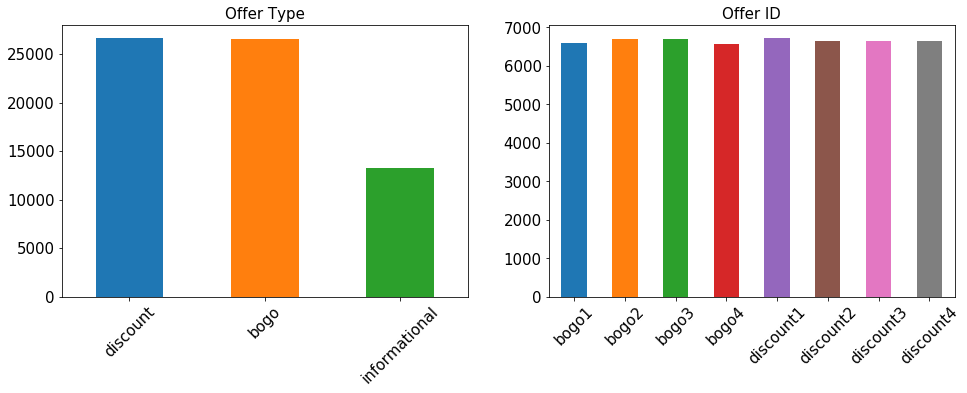

In [37]:
# View the offers sent out and received by customers
plt.subplot(1,2,1)
starbucks_data[starbucks_data.event_offer_received == 1].offer_type.value_counts().plot(kind='bar', rot=45, figsize=(16,5))
plt.title('Offer Type', fontsize = '15');
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')

plt.subplot(1,2,2)
offer_order = ['bogo1', 'bogo2', 'bogo3', 'bogo4', 'discount1', 'discount2', 'discount3', 'discount4']
starbucks_data[starbucks_data.event_offer_received == 1].offer_id.value_counts().loc[offer_order].plot(kind='bar', rot=45)
plt.title('Offer ID', fontsize = '15')
plt.xticks(fontsize='15')
plt.yticks(fontsize='15');



> **The 10 different offers recieved were distributed evenly amoungst the customers.  Since there were only 2 informational offers and 4 of both the discount and bogo offers, there are half the number of total informational offers**

In [38]:
# View the distribution of offers received out on the various channels
medium = starbucks_data[starbucks_data['event_offer_received'] == 1]
medium = medium[['ch__email', 'ch__mobile', 'ch__social', 'ch__web']]
medium.apply(pd.Series.value_counts)

,ch__email,ch__mobile,ch__social,ch__web
0.0,NaN,6726,26699,13326
1.0,66501.0,59775,39802,53175


> **The offers were sent out via email the most, and then the mobile app.  It was sent out via a social channel the least.**

### Customer Demographics

In [39]:
# View the demographic summary
profile_clean.describe()

,age,income,female,male,other_gender,days_member
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,0.413423,0.572277,0.014300,1656.478988
std,17.383705,21598.299410,0.492464,0.494765,0.118729,419.205158
min,18.000000,30000.000000,0.000000,0.000000,0.000000,1134.000000
25%,42.000000,49000.000000,0.000000,0.000000,0.000000,1342.000000
50%,55.000000,64000.000000,0.000000,1.000000,0.000000,1492.000000
75%,66.000000,80000.000000,1.000000,1.000000,0.000000,1931.000000
max,101.000000,120000.000000,1.000000,1.000000,1.000000,2957.000000


In [40]:
# View the distribution of gender
profile_clean.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

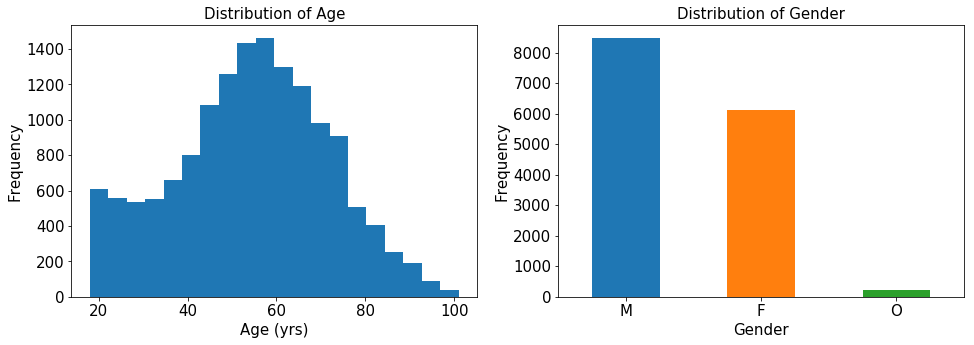

In [41]:
# View the distribution of the age and gender of our customer base
plt.figure(figsize = (16,5))

plt.subplot(1,2,1)
plt.hist(profile_clean[profile_clean.age <= 101].age, 20);
plt.xlabel("Age (yrs)", fontsize = '15')
#plt.xticks(rotation=90) 
plt.ylabel("Frequency", fontsize = '15')
plt.title("Distribution of Age", fontsize = '15')
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')

plt.subplot(1,2,2)
ax = profile_clean['gender'].value_counts().plot(kind='bar', rot = 0)
ax.set_xlabel("Gender", fontsize = '15')
ax.set_ylabel("Frequency", fontsize = '15')
plt.title("Distribution of Gender", fontsize = '15')
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')
plt.show();

> **There were more male customers than female customers in our profile data, with very few other gender.  The age of the customers is approaching a normal distribution but truncated on the left side with slightly more in the younger ages than the older ages**

In [42]:
# View the distribution (percentage) of gender by age groups
pd.crosstab(profile_clean['age_cat'], profile_clean['gender'], normalize='columns', margins=True)

gender,F,M,O,All
age_cat,,,,
0-30,0.077990,0.142504,0.084906,0.242159
31-40,0.085169,0.123645,0.122642,0.111029
41-50,0.146517,0.171735,0.169811,0.196290
51-60,0.256812,0.230198,0.297170,0.115008
61-70,0.216512,0.182579,0.160377,0.161282
71-80,0.125795,0.100424,0.108491,0.107723
81+,0.091206,0.048916,0.056604,0.066509


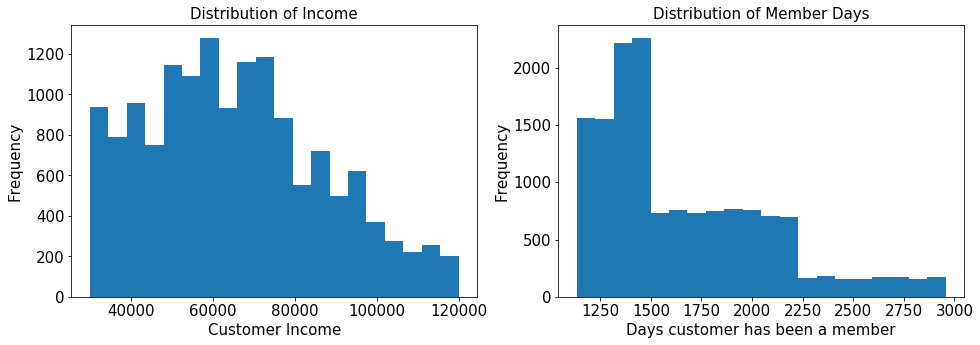

In [43]:
# View the distribution of the customer income and customer length of time
plt.figure(figsize = (16,5))

plt.subplot(1,2,1)
plt.hist(profile_clean[profile_clean.income > 0].income, 20);
plt.xlabel("Customer Income", fontsize = '15')
plt.ylabel("Frequency", fontsize = '15')
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')
plt.title("Distribution of Income", fontsize = '15')

plt.subplot(1,2,2)
plt.hist(profile_clean.days_member, 20);
plt.xlabel("Days customer has been a member", fontsize = '15')
plt.ylabel("Frequency", fontsize = '15')
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')
plt.title("Distribution of Member Days", fontsize = '15');

> **The income of the customers is truncated on the left with more customers in the lower income groups.  The length of time a customer has been a member is truncated on the left with less customers being long time members.**

In [44]:
# View the distribution (percentage) of gender by income groups
pd.crosstab(profile_clean['income_cat'], profile_clean['gender'], normalize='columns', margins=True)

gender,F,M,O,All
income_cat,,,,
0-45k,0.143743,0.252593,0.193396,0.145767
46-60k,0.202643,0.273927,0.292453,0.254772
61-75k,0.244738,0.263083,0.212264,0.244722
76k-90k,0.192201,0.110325,0.221698,0.147993
91-120k,0.216675,0.100071,0.080189,0.206745


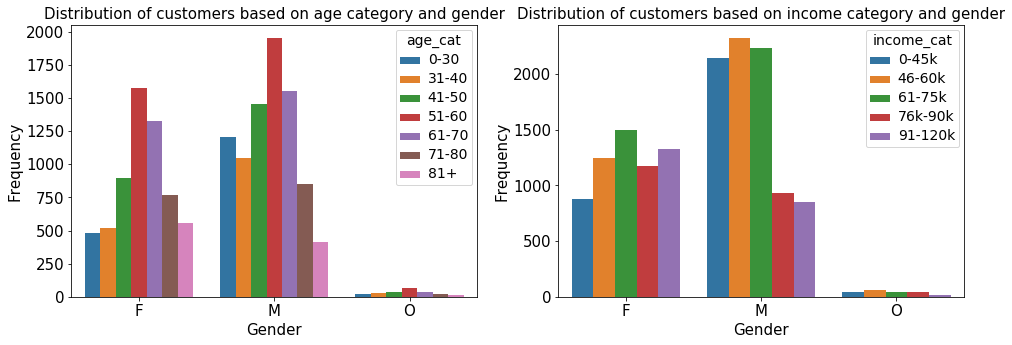

In [45]:
# View the income and age distributions by gender
plt.figure(figsize = (16,5))

plt.subplot(1,2,1)
#grp_temp1 = profile_clean.groupby(['gender', 'age_cat']).size()
#print(grp_temp1)
ax = sns.countplot(data=profile_clean, x='gender', hue='age_cat')
plt.setp(ax.get_legend().get_texts(), fontsize = '14')
plt.setp(ax.get_legend().get_title(), fontsize = '14')
plt.xlabel("Gender", fontsize = '15')
plt.ylabel("Frequency", fontsize = '15')
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')
plt.title("Distribution of customers based on age category and gender", fontsize = '15')

plt.subplot(1,2,2)
#grp_temp2 = profile_clean.groupby(['gender', 'income_cat']).size()
#print(grp_temp2)
ax =sns.countplot(data=profile_clean, x='gender', hue='income_cat')
plt.setp(ax.get_legend().get_texts(), fontsize = '14')
plt.setp(ax.get_legend().get_title(), fontsize = '14')
plt.xlabel("Gender", fontsize = '15')
plt.ylabel("Frequency", fontsize = '15')
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')
plt.title("Distribution of customers based on income category and gender", fontsize = '15');


In [46]:
grp_gender = profile_clean.groupby('gender')
grp_gender.age.mean()

gender
F    57.544950
M    52.116690
O    54.400943
Name: age, dtype: float64

In [47]:
grp_gender.income.mean()

gender
F    71306.412139
M    61194.601603
O    63287.735849
Name: income, dtype: float64

> **It appears that there are more females in the older age groups than males and that there are proportionally more males in the younger age groups.  Also the males seem to be in the lower income brackets compared to the females that are somewhat evenly distributed across the income groups.**

### Purchase Analysis (all transactions)

In [48]:
# Create a dataframe of purchase summary data per customer
def cust_tran_summary(transcript_clean, profile_clean):
    '''
    This function summarizes the customer purchases for analysis
    
    INPUT:
    transcript_clean - dataframe containing cleaned records for transactions, offers received, offers viewed, 
    and offers completed
    
    profile_clean - dataframe containing cleaned demographic data for each customer
    
    OUTPUT:
    profile_trans - profile dataframe including customer purchase summary
    '''    
    
    # Group the purchases (event_transaction == 1) by customer id 
    trans_events = transcript_clean[transcript_clean.event_transaction == 1].groupby('customer_id')
    # Calculate the total purchsed amount by customer
    purchase_total = trans_events[['customer_id', 'amount']].sum()
    purchase_total.rename(columns={'amount':'purchase_total'}, inplace=True)    
    
    # Calculate the average purchsed amount by customer
    purchase_ave = trans_events[['customer_id', 'amount']].mean()
    purchase_ave.rename(columns={'amount':'purchase_ave'}, inplace=True)      
    
    # Calculate the number of purchses by customer
    transactions = trans_events[['customer_id', 'amount']].count()
    transactions.rename(columns={'amount':'num_trxns'}, inplace=True)    
    transactions.drop('customer_id', axis = 1, inplace = True)  
    
    #Merge transaction summary data to the profile data
    profile_trans = pd.merge(profile_clean, purchase_total, on = 'customer_id', how = 'left')
    profile_trans = pd.merge(profile_trans, purchase_ave, on = 'customer_id', how = 'left')  
    profile_trans = pd.merge(profile_trans, transactions, on = 'customer_id', how = 'left') 
    profile_trans['purchase_total'].fillna(0, inplace=True)
    profile_trans['purchase_ave'].fillna(0, inplace=True)    
    profile_trans['num_trxns'].fillna(0, inplace=True)
       
    return profile_trans

In [49]:
# Apply the cust_tran_summary function to create the dataframe
profile_trans = cust_tran_summary(transcript_clean, profile_clean)
profile_trans.head()

,age,became_member_on,gender,customer_id,income,female,male,other_gender,days_member,age_cat,income_cat,member_cat,purchase_total,purchase_ave,num_trxns
0,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,1510,51-60,91-120k,1501-2000,77.01,25.670000,3.0
1,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,1577,71-80,91-120k,1501-2000,159.27,22.752857,7.0
2,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,1225,61-70,61-75k,0-1500,57.73,19.243333,3.0
3,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,1301,61-70,46-60k,0-1500,36.43,12.143333,3.0
4,58.0,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,1391,51-60,46-60k,0-1500,15.62,3.905000,4.0


In [50]:
#profile_trans.shape

In [51]:
profile_trans.describe()

,age,income,female,male,other_gender,days_member,purchase_total,purchase_ave,num_trxns
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,0.413423,0.572277,0.014300,1656.478988,117.028155,14.909689,8.361349
std,17.383705,21598.299410,0.492464,0.494765,0.118729,419.205158,129.965016,16.511923,5.182667
min,18.000000,30000.000000,0.000000,0.000000,0.000000,1134.000000,0.000000,0.000000,0.000000
25%,42.000000,49000.000000,0.000000,0.000000,0.000000,1342.000000,31.450000,3.701429,4.000000
50%,55.000000,64000.000000,0.000000,1.000000,0.000000,1492.000000,87.040000,13.988333,7.000000
75%,66.000000,80000.000000,1.000000,1.000000,0.000000,1931.000000,160.900000,21.298750,11.000000
max,101.000000,120000.000000,1.000000,1.000000,1.000000,2957.000000,1608.690000,451.470000,36.000000


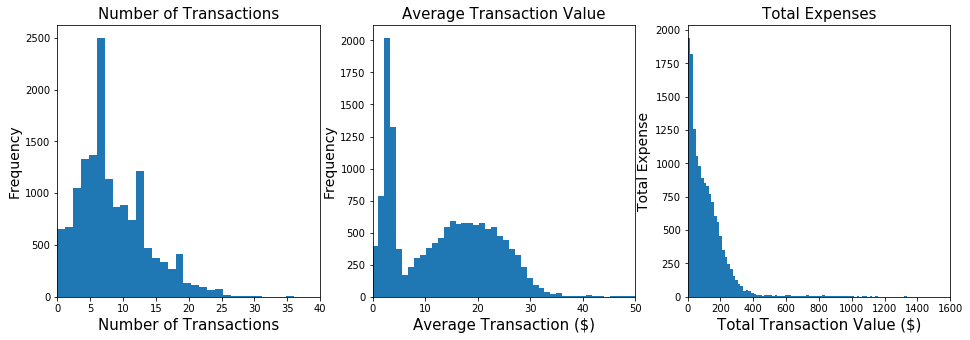

In [52]:
# View the purchase data by Customer
plt.figure(figsize = (16,5))

plt.subplot(1,3,1)
plt.hist(profile_trans.num_trxns, bins=30)
plt.xlabel("Number of Transactions", fontsize = '15')
plt.ylabel("Frequency", fontsize = '14')
plt.title("Number of Transactions", fontsize = '15')
ax = plt.gca()
ax.set_xlim(0,40)

plt.subplot(1,3,2)
plt.hist(profile_trans.purchase_ave, bins=400)
plt.xlabel("Average Transaction ($)", fontsize = '15')
plt.ylabel("Frequency", fontsize = '14')
plt.title("Average Transaction Value", fontsize = '15');
ax = plt.gca()
ax.set_xlim(0,50)

plt.subplot(1,3,3)
plt.hist(profile_trans.purchase_total, bins=100)
plt.xlabel("Total Transaction Value ($)", fontsize = '15')
plt.ylabel("Total Expense", fontsize = '14')
plt.title("Total Expenses", fontsize = '15')
ax = plt.gca()
ax.set_xlim(0,1600);

> **Both the number of transactions and the total transaction value per customer are skewed to the right, with more customers making fewer transactions and the total value the customer spent is in the lower range.  There appears to be a bimodal distribution for the average transaction made by the customers.  It seems a lot of customers buy small purchases like a coffee more often.**

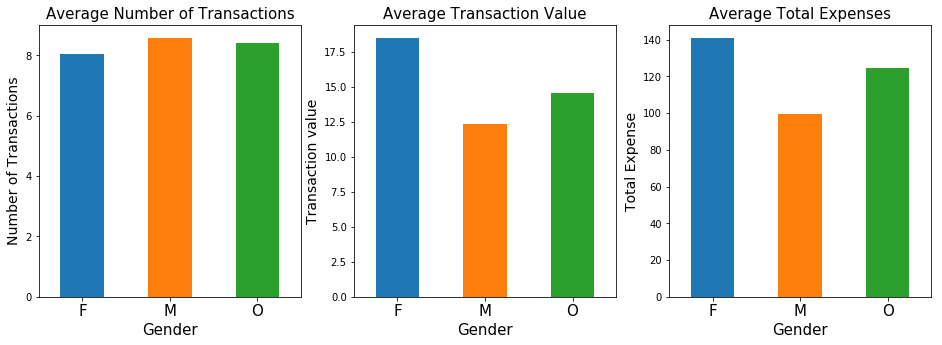

In [54]:
# View the transaction summary by Gender
plt.figure(figsize = (16,5))

grp_gender = profile_trans.groupby('gender')

plt.subplot(1,3,1)
grp_gender.num_trxns.mean().plot(kind='bar', rot = 0)
plt.xlabel("Gender", fontsize = '15')
plt.ylabel("Number of Transactions", fontsize = '14')
plt.title("Average Number of Transactions", fontsize = '15')
plt.xticks(fontsize='15')

plt.subplot(1,3,2)
grp_gender.purchase_ave.mean().plot(kind='bar', rot = 0)
plt.xlabel("Gender", fontsize = '15')
plt.ylabel("Transaction value", fontsize = '14')
plt.title("Average Transaction Value", fontsize = '15')
plt.xticks(fontsize='15')

plt.subplot(1,3,3)
grp_gender.purchase_total.mean().plot(kind='bar', rot = 0)
plt.xlabel("Gender", fontsize = '15')
plt.ylabel("Total Expense", fontsize = '14')
plt.title("Average Total Expenses", fontsize = '15')
plt.xticks(fontsize='15');

> **The average number of transactions per customer seem to be very similar for each gender type, but the females seem to spend more per transaction and also spend the most overall.**

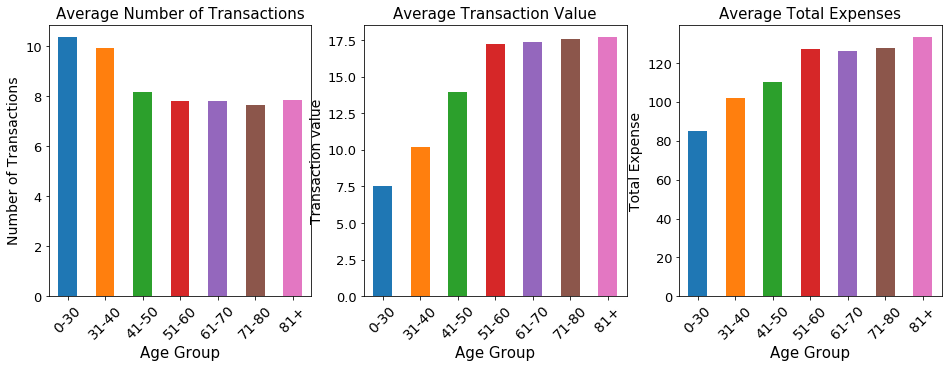

In [55]:
# View the transaction summary by Age Groups
plt.figure(figsize = (16,5))

grp_age = profile_trans.groupby('age_cat')

plt.subplot(1,3,1)
grp_age.num_trxns.mean().plot(kind='bar', rot = 45)
plt.xlabel("Age Group", fontsize = '15')
plt.ylabel("Number of Transactions", fontsize = '14')
plt.title("Average Number of Transactions", fontsize = '15')
plt.xticks(fontsize='14')
plt.yticks(fontsize='13')

plt.subplot(1,3,2)
grp_age.purchase_ave.mean().plot(kind='bar', rot = 45)
plt.xlabel("Age Group", fontsize = '15')
plt.ylabel("Transaction value", fontsize = '14')
plt.title("Average Transaction Value", fontsize = '15')
plt.xticks(fontsize='14')
plt.yticks(fontsize='13')

plt.subplot(1,3,3)
grp_age.purchase_total.mean().plot(kind='bar', rot = 45)
plt.xlabel("Age Group", fontsize = '15')
plt.ylabel("Total Expense", fontsize = '14')
plt.title("Average Total Expenses", fontsize = '15')
plt.xticks(fontsize='14')
plt.yticks(fontsize='13');

> **The younger age groups seem to make more purchases than the older age groups, yet the older age groups spend more per transaction and more overall. The average transaction value and total expenses increase as age increases as expected.**

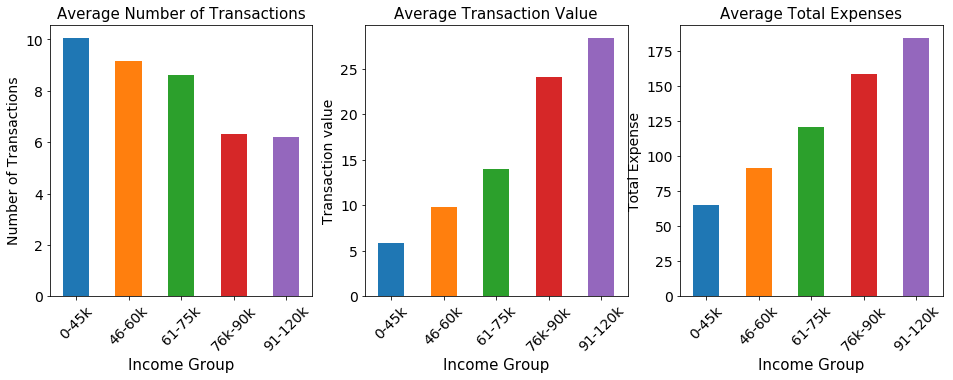

In [56]:
# View the transaction summary by Income Groups
plt.figure(figsize = (16,5))

grp_income = profile_trans.groupby('income_cat')

plt.subplot(1,3,1)
grp_income.num_trxns.mean().plot(kind='bar', rot = 45)
plt.xlabel("Income Group", fontsize = '15')
plt.ylabel("Number of Transactions", fontsize = '14')
plt.title("Average Number of Transactions", fontsize = '15')
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')

plt.subplot(1,3,2)
grp_income.purchase_ave.mean().plot(kind='bar', rot = 45)
plt.xlabel("Income Group", fontsize = '15')
plt.ylabel("Transaction value", fontsize = '14')
plt.title("Average Transaction Value", fontsize = '15')
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')

plt.subplot(1,3,3)
grp_income.purchase_total.mean().plot(kind='bar', rot = 45)
plt.xlabel("Income Group", fontsize = '15')
plt.ylabel("Total Expense", fontsize = '14')
plt.title("Average Total Expenses", fontsize = '15')
plt.xticks(fontsize='14')
plt.yticks(fontsize='14');

> **The lower income groups seem to make more purchases than the higher income groups, yet the higher income groups spend more per transaction and more overall which makes sense.  The average transaction value and total expenses increases as income does as expected.**

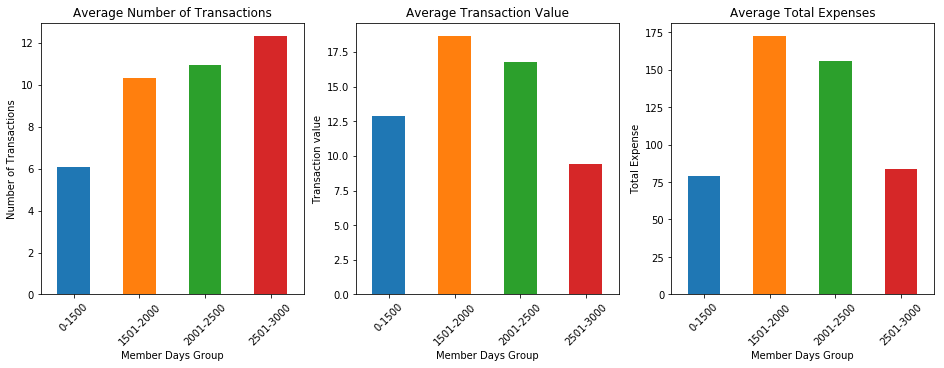

In [57]:
# View the transaction summary by Length of time customers were members
plt.figure(figsize = (16,5))

grp_member = profile_trans.groupby('member_cat')

plt.subplot(1,3,1)
grp_member.num_trxns.mean().plot(kind='bar', rot = 45)
plt.xlabel("Member Days Group")
plt.ylabel("Number of Transactions")
plt.title("Average Number of Transactions")

plt.subplot(1,3,2)
grp_member.purchase_ave.mean().plot(kind='bar', rot = 45)
plt.xlabel("Member Days Group")
plt.ylabel("Transaction value")
plt.title("Average Transaction Value")

plt.subplot(1,3,3)
grp_member.purchase_total.mean().plot(kind='bar', rot = 45)
plt.xlabel("Member Days Group")
plt.ylabel("Total Expense")
plt.title("Average Total Expenses");

> **The customers who have been members longer seem to make more purchases, but yet they spend the least per purchase and overall. This makes me assume the customers  who have been members longer are actually the younger and the lower income customers.** 

In [58]:
no_offer_received = cust_offer_details[cust_offer_details.event_offer_received == 0]
no_offer_received.head()

,amount,customer_id,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,time_completed,time_received,time_trxn,time_viewed,difficulty,duration,offer_type,reward,ch__email,ch__mobile,ch__social,ch__web,event_offer_viewed2,offer_id2,offer_type2,responded_to_offer,offer_responded_to,offer_id_responded_to,offer_response,age,became_member_on,gender,income,female,male,other_gender,days_member,age_cat,income_cat,member_cat
1,12.36,0009655768c64bdeb2e877511632db8f,0,0,0,1,No offer,NaN,NaN,660.0,NaN,NaN,NaN,No offer,NaN,NaN,NaN,NaN,NaN,0,No offer,No offer,0,no offer response,no offer response,no offer,33.0,2017-04-21,M,72000.0,0,1,0,1595,31-40,61-75k,1501-2000
2,28.16,0009655768c64bdeb2e877511632db8f,0,0,0,1,No offer,NaN,NaN,690.0,NaN,NaN,NaN,No offer,NaN,NaN,NaN,NaN,NaN,0,No offer,No offer,0,no offer response,no offer response,no offer,33.0,2017-04-21,M,72000.0,0,1,0,1595,31-40,61-75k,1501-2000
3,18.41,0009655768c64bdeb2e877511632db8f,0,0,0,1,No offer,NaN,NaN,696.0,NaN,NaN,NaN,No offer,NaN,NaN,NaN,NaN,NaN,0,No offer,No offer,0,no offer response,no offer response,no offer,33.0,2017-04-21,M,72000.0,0,1,0,1595,31-40,61-75k,1501-2000
4,13.56,0009655768c64bdeb2e877511632db8f,0,0,0,1,No offer,NaN,NaN,552.0,NaN,NaN,NaN,No offer,NaN,NaN,NaN,NaN,NaN,0,No offer,No offer,0,no offer response,no offer response,no offer,33.0,2017-04-21,M,72000.0,0,1,0,1595,31-40,61-75k,1501-2000
5,22.16,0009655768c64bdeb2e877511632db8f,0,0,0,1,No offer,NaN,NaN,228.0,NaN,NaN,NaN,No offer,NaN,NaN,NaN,NaN,NaN,0,No offer,No offer,0,no offer response,no offer response,no offer,33.0,2017-04-21,M,72000.0,0,1,0,1595,31-40,61-75k,1501-2000


### Offer Analysis

#### Offers received

In [59]:
# View the distribution of offers received
#cust_offer_details.offer_id.value_counts().sort_index()

In [60]:
# View the distribution of offer types received from our cleaned data
cust_offer_details[cust_offer_details['event_offer_received'] == 1].offer_type.value_counts().sort_index()

bogo             22062
discount         22119
informational    11041
Name: offer_type, dtype: int64

In [61]:
# View the distribution of offers received by gender
pd.crosstab(cust_offer_details[cust_offer_details['event_offer_received'] == 1].offer_type,cust_offer_details[cust_offer_details['event_offer_received'] == 1].gender)

gender,F,M,O
offer_type,,,
bogo,9097,12662,303
discount,9110,12706,303
informational,4601,6277,163


In [62]:
# View the percentages of offers received by gender
pd.options.display.float_format = '{:.2f}'.format
pd.crosstab(cust_offer_details[cust_offer_details['event_offer_received'] == 1].offer_type,cust_offer_details[cust_offer_details['event_offer_received'] == 1].gender, normalize='columns', margins=True)

gender,F,M,O,All
offer_type,,,,
bogo,0.40,0.40,0.39,0.40
discount,0.40,0.40,0.39,0.40
informational,0.20,0.20,0.21,0.20


In [63]:
pd.crosstab(cust_offer_details[cust_offer_details['event_offer_received'] == 1].offer_id,cust_offer_details[cust_offer_details['event_offer_received'] == 1].gender, normalize='columns', margins=True)

gender,F,M,O,All
offer_id,,,,
bogo1,0.10,0.10,0.08,0.10
bogo2,0.10,0.10,0.11,0.10
bogo3,0.10,0.10,0.10,0.10
bogo4,0.10,0.10,0.10,0.10
discount1,0.10,0.10,0.10,0.10
discount2,0.10,0.10,0.11,0.10
discount3,0.10,0.10,0.09,0.10
discount4,0.10,0.10,0.09,0.10
info1,0.10,0.10,0.11,0.10


> **It appears that each specific offer type was distributed evenly amoung the gender types**

#### Offers viewed (for those who received an offer)

In [64]:
# View the distribution of offers viewed for those who recieved an offer
df1 = cust_offer_details[cust_offer_details['event_offer_received'] == 1]
df1[df1['event_offer_received'] == 1].event_offer_viewed.value_counts().sort_index()

0    12729
1    42493
Name: event_offer_viewed, dtype: int64

In [65]:
# View the distribution of those who viewed the offer after their purchase
cust_offer_details[cust_offer_details['event_offer_viewed2'] == 0].event_offer_viewed.value_counts().sort_index()

0    101779
1      4272
Name: event_offer_viewed, dtype: int64

In [66]:
# View the distribution of offers viewed for those who recieved an offer by gender
pd.crosstab(df1.gender,df1.event_offer_viewed2, normalize='index', margins=True)

event_offer_viewed2,0,1
gender,,
F,0.31,0.69
M,0.31,0.69
O,0.23,0.77
All,0.31,0.69


> **Of the offers recieved by customers, 42493 offers were viewed, but 4272 of these were viewed after the offer was completed.  Customers probably wanted to view the offer they completed when they saved money.  I will consider these as not responding to the offer (event_offer_viewed2)**

In [67]:
# For those that received an offer, view the distribution of the specific offers that were viewed (excluding those 
# viewed after thier purchase)
pd.crosstab(df1.offer_id,df1.event_offer_viewed2, normalize='index', margins=True)

event_offer_viewed2,0,1
offer_id,,
bogo1,0.13,0.87
bogo2,0.54,0.46
bogo3,0.22,0.78
bogo4,0.15,0.85
discount1,0.69,0.31
discount2,0.14,0.86
discount3,0.54,0.46
discount4,0.12,0.88
info1,0.45,0.55


> **There were offers in each offer type that were viewed the most, not making one specific offer stand out as being viewed the most**

In [68]:
# For those that received an offer, view the distribution of the specific offer types that were viewed (excluding 
# those viewed after thier purchase)
pd.crosstab(df1.offer_type,df1.event_offer_viewed2, margins=True)

event_offer_viewed2,0,1,All
offer_type,,,
bogo,5716,16346,22062
discount,8224,13895,22119
informational,3061,7980,11041
All,17001,38221,55222


In [69]:
# View percentages
pd.crosstab(df1['offer_type'], df1['event_offer_viewed2'], normalize='index', margins=True)

event_offer_viewed2,0,1
offer_type,,
bogo,0.26,0.74
discount,0.37,0.63
informational,0.28,0.72
All,0.31,0.69


> **For each offer type sent out, they were each proportionally viewed about the same amount, with the bogo offer viewed the slightly more**

#### Offers completed

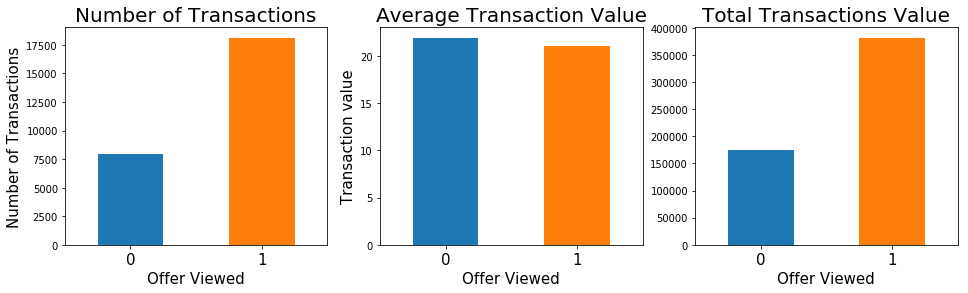

In [70]:
# View the transaction summary for the offers that were completed by those viewed and not viewed (prior to completing)
plt.figure(figsize = (16,4))

df5 = cust_offer_details[cust_offer_details['event_offer_completed'] == 1]
grp_compl = df5.groupby('event_offer_viewed2')

plt.subplot(1,3,1)
grp_compl.amount.count().plot(kind='bar', rot = 0)
plt.xlabel("Offer Viewed", fontsize = '15')
plt.ylabel("Number of Transactions", fontsize = '15')
plt.xticks(fontsize='18')
plt.xticks(fontsize='15')
plt.title("Number of Transactions", fontsize = '20')

plt.subplot(1,3,2)
grp_compl.amount.mean().plot(kind='bar', rot = 0)
plt.xlabel("Offer Viewed", fontsize = '15')
plt.ylabel("Transaction value", fontsize = '15')
plt.xticks(fontsize='18')
plt.xticks(fontsize='15')
plt.title("Average Transaction Value", fontsize = '20');

plt.subplot(1,3,3)
grp_compl.amount.sum().plot(kind='bar', rot = 0)
plt.xlabel("Offer Viewed", fontsize = '15')
#plt.ylabel("Transaction value", fontsize = '15')
plt.xticks(fontsize='18')
plt.xticks(fontsize='15')
plt.title("Total Transactions Value", fontsize = '20');

#### Offers responded to (completed)

In [71]:
# View the total number of purchases in the dataset
cust_offer_details.event_transaction.value_counts().sort_index()

0     26304
1    117968
Name: event_transaction, dtype: int64

In [72]:
# View the number of completed reward offers in the dataset (regardless if they viewed their offer or not)
df2 = cust_offer_details[(cust_offer_details['offer_type'] == 'bogo') | (cust_offer_details['offer_type'] == 'discount')]
df2.event_offer_completed.value_counts().sort_index()

0    16239
1    27942
Name: event_offer_completed, dtype: int64

In [73]:
# For those who recieved a reward offer (bogo or discount), view the distribution of the offers completed for those who 
# viewed prior to their purchase versus those who did not view the offer (or post completion)
pd.crosstab(df2.event_offer_viewed2,df2.event_offer_completed, margins=True)

event_offer_completed,0,1,All
event_offer_viewed2,,,
0,5311,8629,13940
1,10928,19313,30241
All,16239,27942,44181


In [74]:
# View the percentages
pd.crosstab(df2['event_offer_viewed2'], df2['event_offer_completed'], normalize='columns', margins=True)

event_offer_completed,0,1,All
event_offer_viewed2,,,
0,0.33,0.31,0.32
1,0.67,0.69,0.68


> **For those that received a reward offer (bogo or discount), it appears that viewing the offer prior to completing the offer does not affect whether a customer will complete the offer.  The same proportion of customers who did not view their offer completed an offer as did those who viewed their offer**

In [75]:
# View the distribution of events completed by offer type for those who viewed their offer (those who did not view the 
# offer or did not view the offer prior to the purchase are considered 'no offer')
df3 = cust_offer_details[cust_offer_details['offer_type2'] != 'No offer']
pd.crosstab(df3.offer_type2,df3.event_offer_completed, margins=True)

event_offer_completed,0,1,All
offer_type2,,,
bogo,7175,9171,16346
discount,3753,10142,13895
informational,7980,0,7980
All,18908,19313,38221


In [76]:
# View the percentages
pd.crosstab(df3['offer_type2'], df3['event_offer_completed'], normalize='index', margins=True)

event_offer_completed,0,1
offer_type2,,
bogo,0.44,0.56
discount,0.27,0.73
informational,1.00,0.00
All,0.49,0.51


In [77]:
# View the percentages
pd.crosstab(df3['offer_id2'], df3['event_offer_completed'], normalize='index', margins=True)

event_offer_completed,0,1
offer_id2,,
bogo1,0.52,0.48
bogo2,0.27,0.73
bogo3,0.50,0.50
bogo4,0.39,0.61
discount1,0.31,0.69
discount2,0.27,0.73
discount3,0.28,0.72
discount4,0.25,0.75
info1,1.00,0.00


> **Of the two types of reward offers sent out and received, the discount offers seems to make customers complete their offers more than the bogo offers did** 

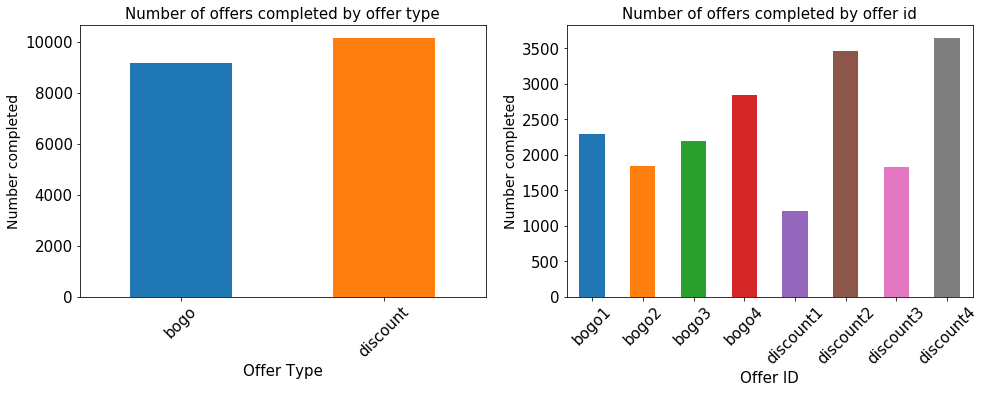

In [78]:
# View the offers completed by offer type and id
plt.figure(figsize = (16,5))

off_typ_comp = df3[df3.offer_type2 != 'informational'].groupby('offer_type2')

plt.subplot(1,2,1)
off_typ_comp.event_offer_completed.sum().plot(kind='bar', rot = 45)
plt.xlabel("Offer Type", fontsize = '15')
plt.ylabel("Number completed", fontsize = '14')
plt.title("Number of offers completed by offer type", fontsize = '15')
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')

off_id_comp = df3[df3.offer_type2 != 'informational'].groupby('offer_id2')

plt.subplot(1,2,2)
off_id_comp.event_offer_completed.sum().plot(kind='bar', rot = 45)
plt.xlabel("Offer ID", fontsize = '15')
plt.ylabel("Number completed", fontsize = '14')
plt.title("Number of offers completed by offer id", fontsize = '15')
plt.xticks(fontsize='15')
plt.yticks(fontsize='15');

#### Transaction summary for those who responsed to an offer

In [79]:
#View the number of transactions (purchases) per reward offer responded to (recieved, viewed and completed)
offer = cust_offer_details[cust_offer_details['offer_response'] == 'offer']

offer.groupby('offer_responded_to')['amount'].count()

offer_responded_to
bogo        8525
discount    9599
Name: amount, dtype: int64

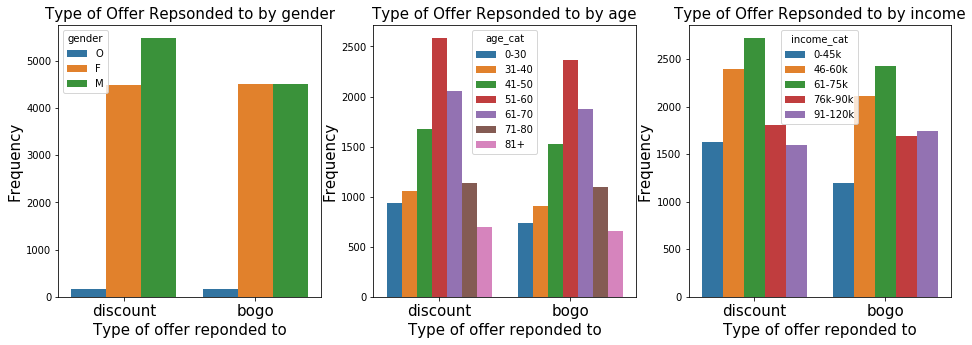

In [80]:
# View the transaction summary by Gender and Offer repsonded to
plt.figure(figsize = (16,5))

plt.subplot(1,3,1)
sns.countplot(data=offer, x='offer_responded_to', hue='gender');
plt.xlabel("Type of offer reponded to", fontsize = '15')
plt.ylabel("Frequency", fontsize = '15')
plt.xticks(fontsize='15')
plt.xticks(fontsize='15')
plt.title("Type of Offer Repsonded to by gender", fontsize = '15')

plt.subplot(1,3,2)
sns.countplot(data=offer, x='offer_responded_to', hue='age_cat');
plt.xlabel("Type of offer reponded to", fontsize = '15')
plt.ylabel("Frequency", fontsize = '15')
plt.xticks(fontsize='15')
plt.xticks(fontsize='15')
plt.title("Type of Offer Repsonded to by age", fontsize = '15');

plt.subplot(1,3,3)
sns.countplot(data=offer, x='offer_responded_to', hue='income_cat');
plt.xlabel("Type of offer reponded to", fontsize = '15')
plt.ylabel("Frequency", fontsize = '15')
plt.xticks(fontsize='15')
plt.xticks(fontsize='15')
plt.title("Type of Offer Repsonded to by income", fontsize = '15');

> **More men seem to respond to the discount offer than females, but both genders respond to the bogo offers the same.  The age distribution seems to be similar for both the discount and bogo offers with slightly more younger age groups reponding to the discount offer than the bogo offer.  The distribution across the income categories also seems similar for repsonse rate, although the lower income groups reponds more to the discount offers.** 

In [81]:
# View the average value of transactions for each offer repsonded to 
offer.groupby('offer_responded_to')['amount'].mean()

offer_responded_to
bogo       22.12
discount   20.10
Name: amount, dtype: float64

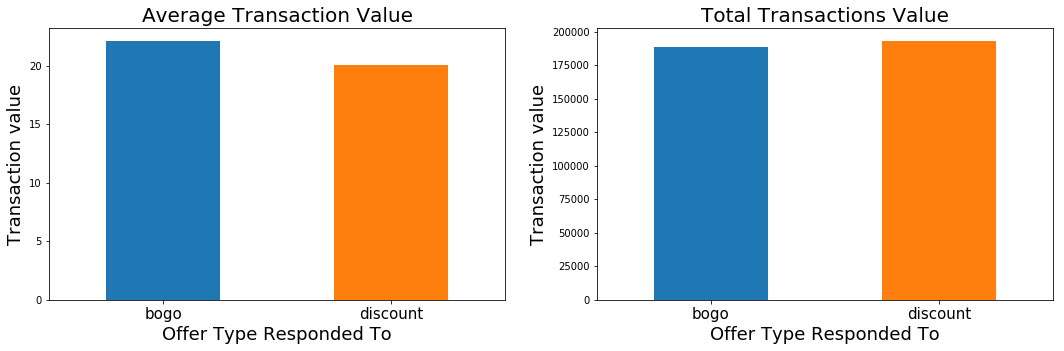

In [82]:
# View the transaction summary by Offer Type
plt.figure(figsize = (18,5))

grp_offer = offer.groupby('offer_responded_to')

plt.subplot(1,2,1)
grp_offer.amount.mean().plot(kind='bar', rot = 0)
plt.xlabel("Offer Type Responded To", fontsize = '18')
plt.ylabel("Transaction value", fontsize = '18')
plt.xticks(fontsize='18')
plt.xticks(fontsize='15')
plt.title("Average Transaction Value", fontsize = '20');

plt.subplot(1,2,2)
grp_offer.amount.sum().plot(kind='bar', rot = 0)
plt.xlabel("Offer Type Responded To", fontsize = '18')
plt.ylabel("Transaction value", fontsize = '18')
plt.xticks(fontsize='18')
plt.xticks(fontsize='15')
plt.title("Total Transactions Value", fontsize = '20');

> **The number of purchases made for discount offers was slightly higher than for the bogo offers.  The average transaction value of the purchases was lower for the discount offers.  This makes sense as more customers can make more purchases if their purchases are less expensive.  The total amount of the transactions for each offer type are similar.**

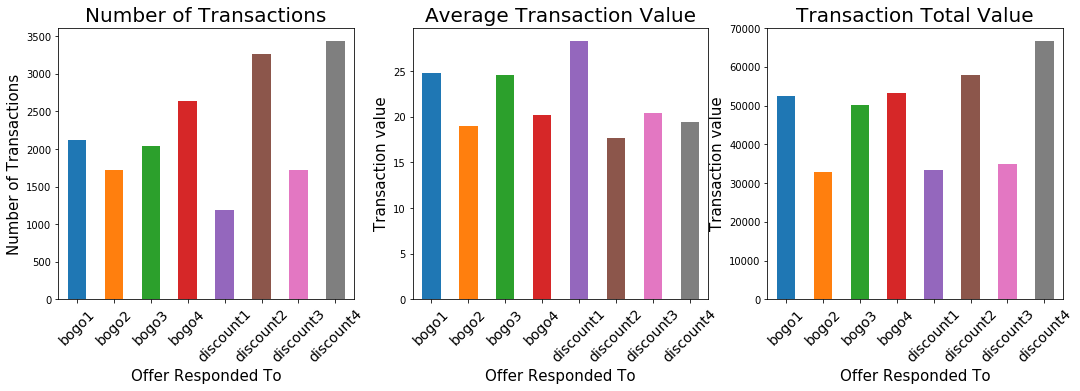

In [83]:
# View the transaction summary by Offer ID
plt.figure(figsize = (18,5))

grp_offer = offer.groupby(['offer_id_responded_to'])

plt.subplot(1,3,1)
grp_offer.amount.count().plot(kind='bar', rot = 45)
plt.xlabel("Offer Responded To", fontsize = '15')
plt.ylabel("Number of Transactions", fontsize = '15')
plt.xticks(fontsize='14')
plt.title("Number of Transactions", fontsize = '20')

plt.subplot(1,3,2)
grp_offer.amount.mean().plot(kind='bar', rot = 45)
plt.xlabel("Offer Responded To", fontsize = '15')
plt.ylabel("Transaction value", fontsize = '15')
plt.xticks(fontsize='14')
plt.title("Average Transaction Value", fontsize = '20');

plt.subplot(1,3,3)
grp_offer.amount.sum().plot(kind='bar', rot = 45)
plt.xlabel("Offer Responded To", fontsize = '15')
plt.ylabel("Transaction value", fontsize = '15')
plt.xticks(fontsize='14')
plt.title("Transaction Total Value", fontsize = '20');


> **It appears that the offer called discount4 (spend 10 dollars, save 2) had the most transactions as well as the highest total transaction value, where as the offer called discount1 (spend 20 dollars, save 5) had the highest average transaction value, but brought in one of the lowest revenue totals.** .  

### Offer recommendations

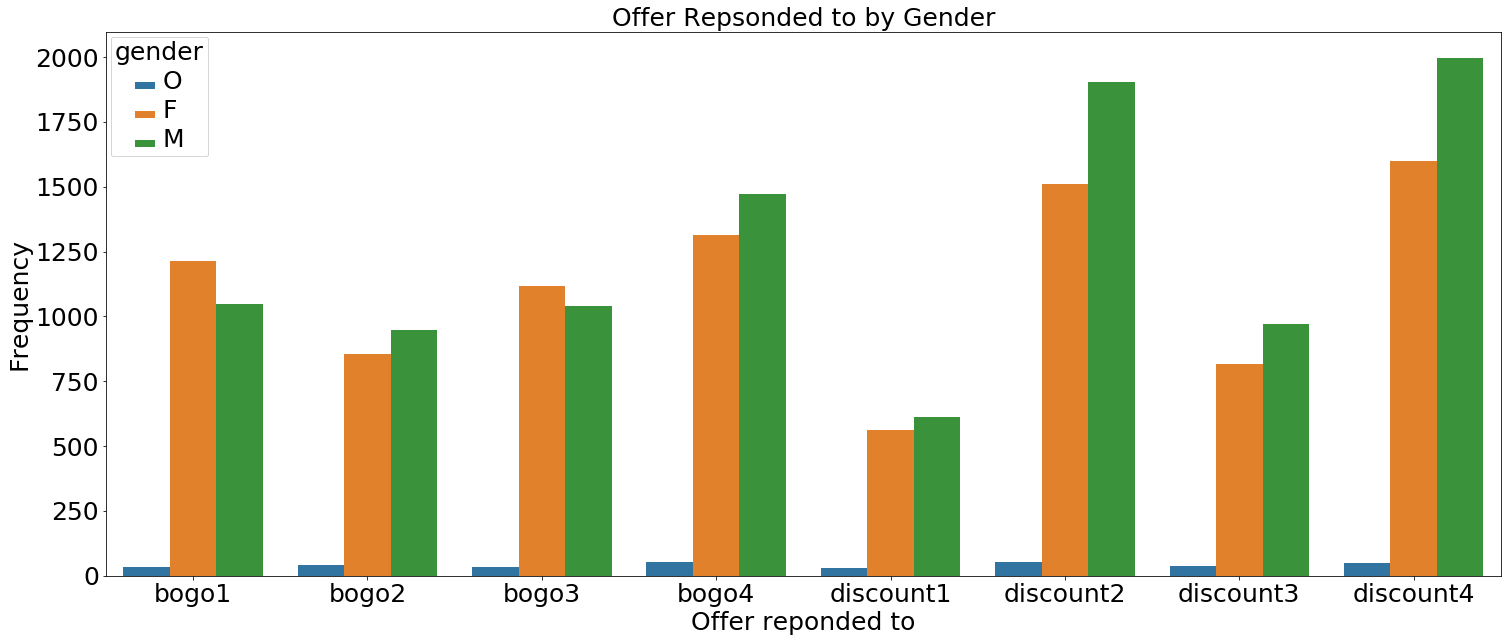

In [84]:
# View the distribution for offers repsonded to by Females
plt.figure(figsize = (25,10))

ax = sns.countplot(data=offer, x='offer_id_responded_to', hue='gender', 
                   order=['bogo1', 'bogo2', 'bogo3', 'bogo4', 'discount1', 'discount2', 'discount3', 'discount4'])
plt.setp(ax.get_legend().get_texts(), fontsize = '25')
plt.setp(ax.get_legend().get_title(), fontsize = '25')
plt.xlabel("Offer reponded to", fontsize = '25')
plt.ylabel("Frequency" , fontsize = '25')
plt.xticks(fontsize='25')
plt.yticks(fontsize='25')
plt.title("Offer Repsonded to by Gender", fontsize = '25')

plt.show();

In [85]:
# View the distribution of customers who responded to the different offers by demographics
pd.crosstab([offer["gender"], offer["age_cat"]], offer["offer_id_responded_to"])

offer_id_responded_to  bogo1  bogo2  bogo3  bogo4  discount1  discount2  \
gender age_cat                                                            
F      0-30               80     44     73    103         26        103   
       31-40              97     69    112    108         49        132   
       41-50             179    144    163    189         93        236   
       51-60             333    215    281    336        150        406   
       61-70             249    194    257    295        122        302   
       71-80             162    112    129    158         78        193   
       81+               113     79    101    126         43        139   
M      0-30               68     89     96    177         46        256   
       31-40             100    103    122    172         59        232   
       41-50             196    191    204    230        126        317   
       51-60             291    248    254    364        174        434   
       61-70             210    159    201    288        107        354   
       71-80             129    115    112    162         70        201   
       81+                55     41     52     80         31        110   
O      0-30                1      3      2      2          1          3   
       31-40               5      5      4      6          3          6   
       41-50               4      9      8     11          8          8   
       51-60              11      7      9     15          9         17   
       61-70               5      5      5     11          1          9   
       71-80               4      9      4      5          5          6   
       81+                 5      2      1      3          3          4   

offer_id_responded_to  discount3  discount4  
gender age_cat                               
F      0-30                   48        109  
       31-40                  69        135  
       41-50                 142        220  
       51-60                 211        428  
       61-70                 185        373  
       71-80                  94        185  
       81+                    67        151  
M      0-30                   74        261  
       31-40                 117        245  
       41-50                 175        330  
       51-60                 266        464  
       61-70                 195        395  
       71-80                  96        199  
       81+                    47        102  
O      0-30                    2          3  
       31-40                   3          9  
       41-50                   4         12  
       51-60                  13         13  
       61-70                   6          5  
       71-80                   7          6  
       81+                     3          1

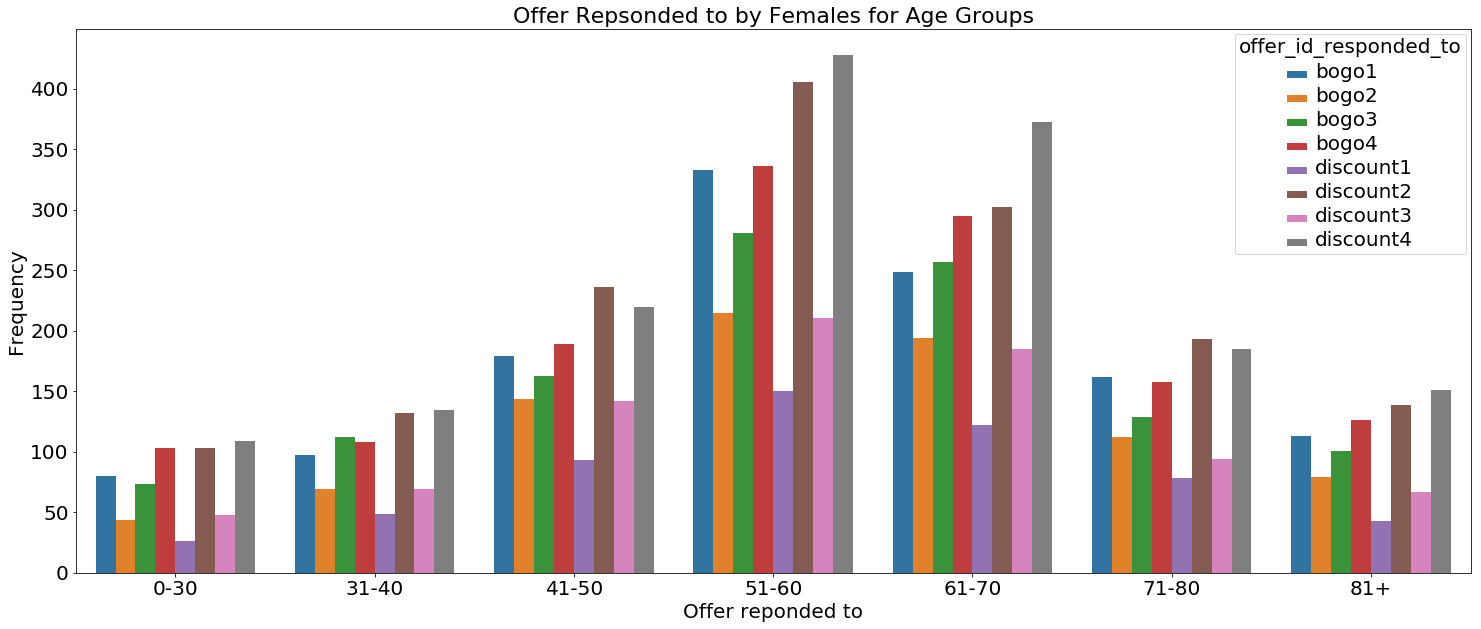

In [86]:
# View the distribution for offers repsonded to by Females
plt.figure(figsize = (25,10))

ax = sns.countplot(data=offer[offer.gender == 'F'], x='age_cat', hue='offer_id_responded_to', 
                   hue_order=['bogo1', 'bogo2', 'bogo3', 'bogo4', 'discount1', 'discount2', 'discount3', 'discount4'])
plt.setp(ax.get_legend().get_texts(), fontsize = '20')
plt.setp(ax.get_legend().get_title(), fontsize = '20')
plt.xlabel("Offer reponded to", fontsize = '20')
plt.ylabel("Frequency" , fontsize = '20')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("Offer Repsonded to by Females for Age Groups", fontsize = '22')

plt.show();

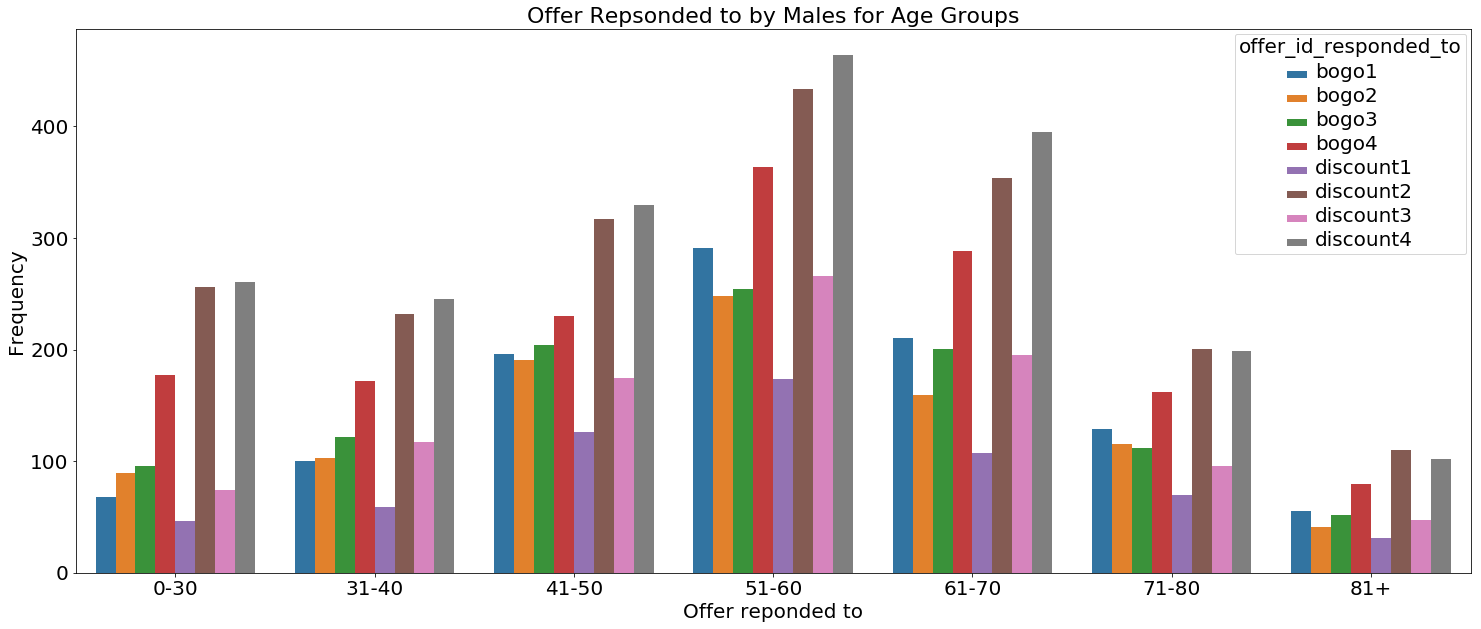

In [87]:
# View the distribution for offers repsonded to by Males
plt.figure(figsize = (25,10))

ax = sns.countplot(data=offer[offer.gender == 'M'], x='age_cat', hue='offer_id_responded_to', 
                   hue_order=['bogo1', 'bogo2', 'bogo3', 'bogo4', 'discount1', 'discount2', 'discount3', 'discount4'])
plt.setp(ax.get_legend().get_texts(), fontsize = '20')
plt.setp(ax.get_legend().get_title(), fontsize = '20')
plt.xlabel("Offer reponded to", fontsize = '20')
plt.ylabel("Frequency" , fontsize = '20')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("Offer Repsonded to by Males for Age Groups", fontsize = '22')

plt.show();

In [88]:
# View the distribution of customers who responded to the different offers by demographics
pd.crosstab([offer["gender"], offer["income_cat"]], offer["offer_id_responded_to"])

offer_id_responded_to  bogo1  bogo2  bogo3  bogo4  discount1  discount2  \
gender income_cat                                                         
F      0-45k             110     88    124    162         49        198   
       46-60k            234    182    230    272        124        302   
       61-75k            318    229    283    303        145        386   
       76k-90k           255    188    228    251        152        309   
       91-120k           296    170    251    327         91        316   
M      0-45k             131    134    154    276         56        420   
       46-60k            243    260    259    386        154        519   
       61-75k            295    267    269    426        182        517   
       76k-90k           188    151    186    203        138        234   
       91-120k           192    134    173    182         83        214   
O      0-45k               3      5      6      7          2         11   
       46-60k              9     10      8     17          8         11   
       61-75k              9      8      9     13          9         14   
       76k-90k            11     12      9     10          8         11   
       91-120k             3      5      1      6          3          6   

offer_id_responded_to  discount3  discount4  
gender income_cat                            
F      0-45k                  89        214  
       46-60k                163        314  
       61-75k                226        390  
       76k-90k               174        321  
       91-120k               164        362  
M      0-45k                 132        439  
       46-60k                257        517  
       61-75k                285        547  
       76k-90k               175        265  
       91-120k               121        228  
O      0-45k                   6          9  
       46-60k                  9         15  
       61-75k                  9         12  
       76k-90k                10          9  
       91-120k                 4          4

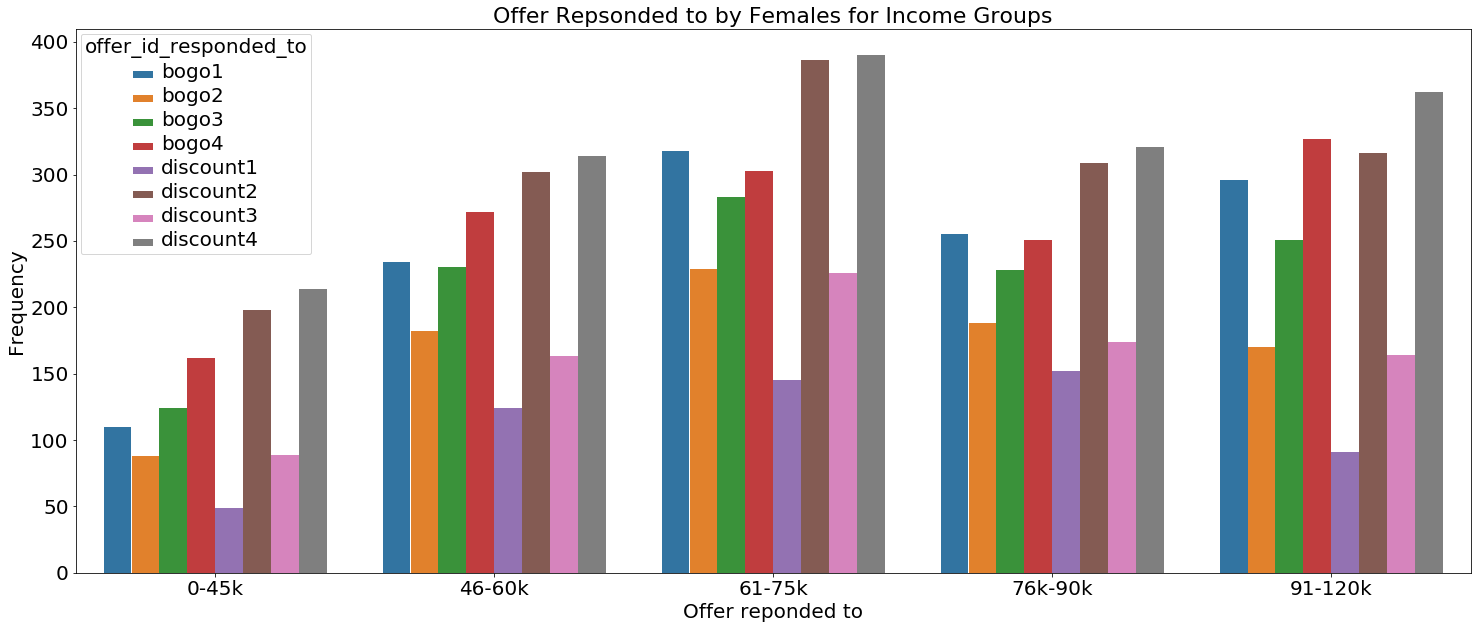

In [89]:
# View the distribution for offers repsonded to by Females
plt.figure(figsize = (25,10))

ax = sns.countplot(data=offer[offer.gender == 'F'], x='income_cat', hue='offer_id_responded_to', 
                   hue_order=['bogo1', 'bogo2', 'bogo3', 'bogo4', 'discount1', 'discount2', 'discount3', 'discount4'])
plt.setp(ax.get_legend().get_texts(), fontsize = '20')
plt.setp(ax.get_legend().get_title(), fontsize = '20')
plt.xlabel("Offer reponded to", fontsize = '20')
plt.ylabel("Frequency" , fontsize = '20')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("Offer Repsonded to by Females for Income Groups", fontsize = '22')

plt.show();

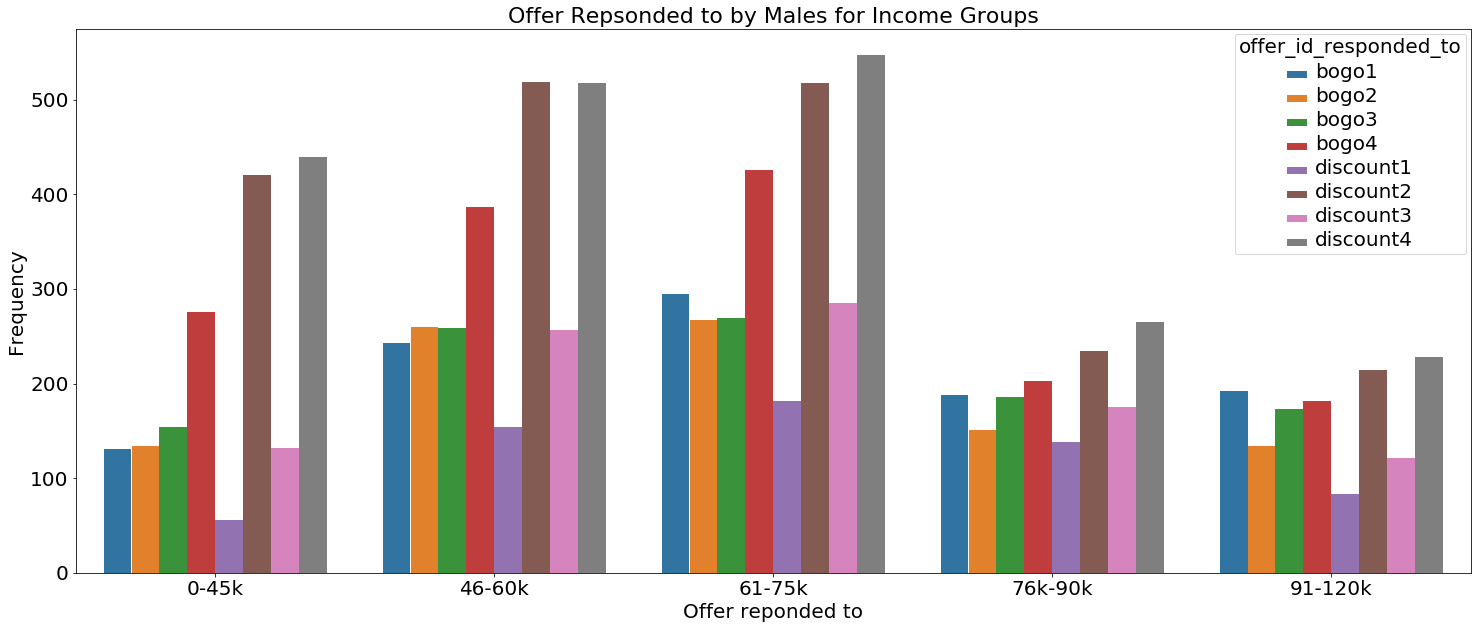

In [90]:
# View the distribution for offers repsonded to by Males
plt.figure(figsize = (25,10))

ax = sns.countplot(data=offer[offer.gender == 'M'], x='income_cat', hue='offer_id_responded_to', 
                   hue_order=['bogo1', 'bogo2', 'bogo3', 'bogo4', 'discount1', 'discount2', 'discount3', 'discount4'])
plt.setp(ax.get_legend().get_texts(), fontsize = '20')
plt.setp(ax.get_legend().get_title(), fontsize = '20')
plt.xlabel("Offer reponded to", fontsize = '20')
plt.ylabel("Frequency" , fontsize = '20')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("Offer Repsonded to by Males for Income Groups", fontsize = '22')

plt.show();

## Conclusion

> **For customers who provide their demographic profile, we can use a knowledge-based recommendation system, where we can filter on age, gender and income to provide the best recommendation. If the goal of sending out offers to the customers is to have the customers complete the offer with the hopeful intent that once in the store they may purchase more than just what is required for the offer. If we were to recommend offers to customers with this goal in mind, we can use the information in the barcharts above to recommend the best offers based on their demographics.**

> **We saw that women tend to spend more money overall and per transaction then men do.  Also the higher age groups and income groups both tend to spend more per transaction and overall than the lower groups as expected.**  

> **Of the different reward offers received, the discount offers tend to be completed more than the bogo offers.  This may be a result of the discount offer allowing you to accumulate your purchases to the expenditure required over time and the bogo must be done in one purchase.  Also, of the discount offers completed, the one that was completed the most was the one that had the longest duration to complete and the second lowest amount of money to spend.  The second best offer to be completed the most was the discount offer with the lowest required amount to spend to complete.** 

> **Looking at the last set of bar charts, we can see per gender/age group and per gender/income group the distribution of the offers that these groups completed and which offers were best responded to.  We can use this information in our recommendation system based on the customers demographic profile.**  
> **For example, females tend to repsond to discount2 and discount4 of the discount offers for all age groups, but of the bogo offers, each age group responds differently to the specific bogo offers.** 


> **For customers that do not wish to complete their demographic profile we could use a simple ranked based recommendation system and recommend the most popular offers (discount4 and discount2).**